Introduction to MDFA in Python
==============================

by [Peter Jurica](http://bsp.brain.riken.jp/~juricap/)

This notebook is a reimplementation of [Introduction to multifractal detrended fluctuation analysis in Matlab](http://journal.frontiersin.org/Journal/10.3389/fphys.2012.00141/full) in Python. 

I have found the tutorial approach of the original article very useful and supported it by a commentary published in the same journal: [Multifractal analysis for all](http://journal.frontiersin.org/article/10.3389/fphys.2015.00027/full). If you find the Python module described on these pages useful you can cite my article as:

    Jurica P. Multifractal analysis for all. Frontiers in Physiology. 2015;6:27. doi:10.3389/fphys.2015.00027.

The notebook shows how to obtain Figures 1-9 with the exception of Figure 6. I have started translating the original MATLAB demo. This demo consisted of computataions in a single continuos file and many plot function, each in a separate m-file. Such approach is awkward for Python, you will find all you need on this single page.

I have a much simpler and faster version of the methods shown here. Python is still not as good as MATLAB in execution in loops. Some parts of the code might feel slow, mostly because of the polyval function. Numpy module actaully offers a vectorized polyfit and polyval (hidden in numpy.polynomials.polynomials). I am showing how to use the vectorized functions in another notebook [Introduction to (faster) MDFA in Python](mdfafast.html)

Both notebooks can be downloaded in ".ipynb" format:

* [Introduction to MDFA in Python.ipynb](mdfaintro.ipynb)
* [Introduction to (faster) MDFA in Python.ipynb](mdfafast.ipynb)

If you like to use the methods described here you can download [pymdfa](http://bsp.brain.riken.jp/~juricap/mdfa/pymdfa.py) and reuse them freely. This script is executable, it demonstrates its use on sample dataset.

This package requires Python modules:

- numpy
- matplotlib
- scipy (for loading the demo data)
- IPython for notebook
- prettyplotlib (and brewer2mpl) included with pymdfa
- and of course dependecies of the above packages

The data for this notebook and some of the python dependencies are in [packages.zip](http://bsp.brain.riken.jp/~juricap/mdfa/packages.zip)

Setup
-----
First we load the demo data. For this we need the scipy module. I will also use the [PrettyPlotLib](http://olgabot.github.io/prettyplotlib/) which changes the defaults of MAtPlotLib functions and maked all plots look better without effort.

In [1]:
import os
def require(fname):
    if not os.path.exists(fname):
        from urllib import urlretrieve
        print 'Downloading %s.'%fname
        urlretrieve('http://bsp.brain.riken.jp/~juricap/mdfa/%s'%fname,fname)
    if fname.endswith('.zip'):
        import zipfile
        try:
            zipfile.ZipFile(fname).extractall()
        except Exception as exc:
            print exc

require('packages.zip')
require('fractaldata.mat')

from prettyplotlib import *
rcParams['figure.figsize'] = (14,8)
from scipy.io import loadmat

o = loadmat('fractaldata.mat')
whitenoise = o['whitenoise']
monofractal = o['monofractal']
multifractal = o['multifractal']
SAVE = False

The rest of the notebook goes without comments, captions and detailed explanation of methods was already done in [Introduction to multifractal detrended fluctuation analysis in Matlab](http://journal.frontiersin.org/Journal/10.3389/fphys.2012.00141/full)

Figure 1
--------

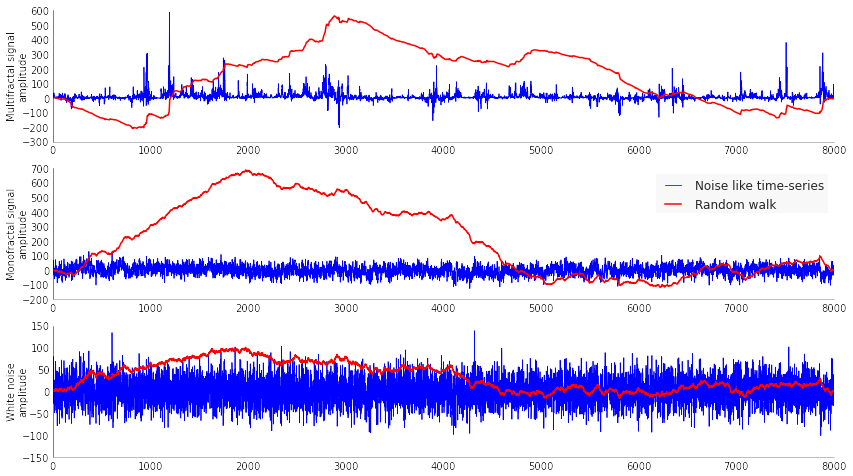

In [2]:
RW1=cumsum(whitenoise-mean(whitenoise));
RW2=cumsum(monofractal-mean(monofractal));
RW3=cumsum(multifractal-mean(multifractal));

A = 30.0
subplot(311)
plot(A*multifractal)
plot(RW3,'r',lw=1.5)
ylabel('Multifractal signal\namplitude',ha='center')
subplot(312)
plot(A*monofractal)
plot(RW2,'r',lw=1.5)
legend(['Noise like time-series','Random walk'])
ylabel('Monofractal signal\namplitude',ha='center')
subplot(313)
plot(A*whitenoise)
plot(RW1,'r',lw=1.5)
ylabel('White noise\namplitude',ha='center')
if SAVE: savefig('figure1.png')

Figure 2
--------

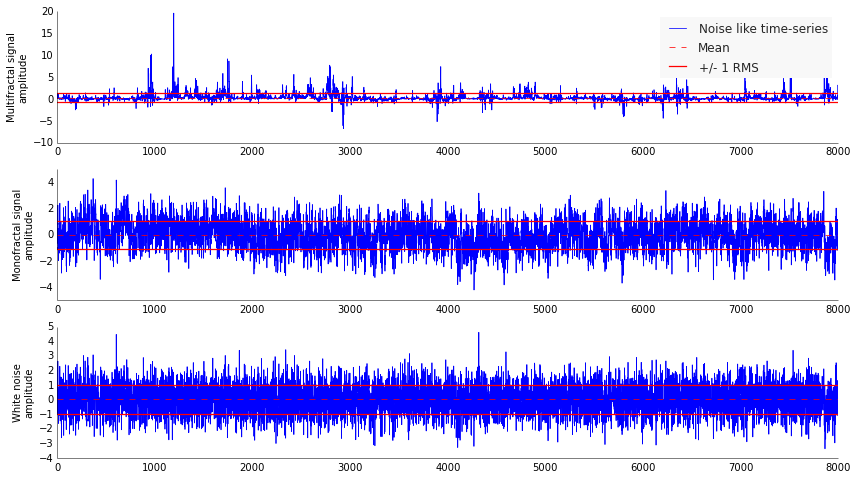

In [3]:
def plot_rms(x,label=''):
    RMS = sqrt((x**2).sum())
    plot(x)
    x0 = x.mean()
    x1 = x.std()
    plot(xlim(),x0*r_[1,1],'r--')
    plot(xlim(),(x0+x1)*r_[1,1],'r-',lw=1.25)
    plot(xlim(),(x0-x1)*r_[1,1],'r-',lw=1.25)
    ylabel(label,ha='center')

subplot(311)
plot_rms(multifractal,'Multifractal signal\namplitude')
legend(['Noise like time-series','Mean','+/- 1 RMS'])
subplot(312)
plot_rms(monofractal,'Monofractal signal\namplitude')
subplot(313)
plot_rms(whitenoise,'White noise\namplitude')
if SAVE: savefig('figure2.png')

Figure 3
--------

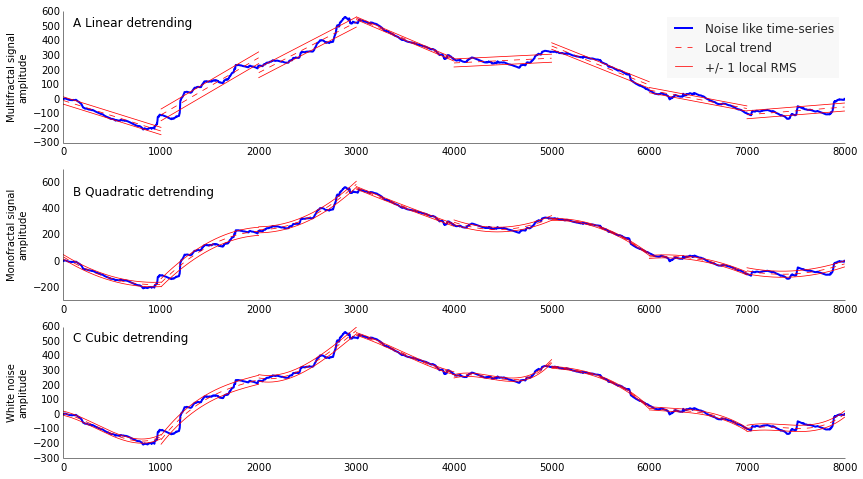

In [4]:
def plot_trends(X,scale,m=1,label='',title=''):
    t = arange(X.shape[0])
    plot(t,X,lw=2.0)
    for i0 in xrange(0,X.shape[0]-scale+1,scale):
        i1 = i0+scale
        t0 = t[i0:i1]
        C = polyfit(t0,X[i0:i1],m)
        fit = polyval(C,t0);
        RMS = sqrt(((X[i0:i1]-fit)**2).mean())
        plot(t0,fit,'r--')
        plot(t0,fit-RMS,'r')
        plot(t0,fit+RMS,'r')
    ylabel(label,ha='center')
    if title: text(100,500,title,fontsize=12) 

scale = 1000
RW = cumsum(multifractal-multifractal.mean())

subplot(311)
plot_trends(RW,scale,1,label='Multifractal signal\namplitude',
            title='A Linear detrending')
legend(['Noise like time-series','Local trend','+/- 1 local RMS'])
subplot(312)
plot_trends(RW,scale,2,label='Monofractal signal\namplitude',
            title='B Quadratic detrending')
subplot(313)
plot_trends(RW,scale,3,label='White noise\namplitude',
            title='C Cubic detrending')

if SAVE: savefig('figure3.png')

Figure 4
--------

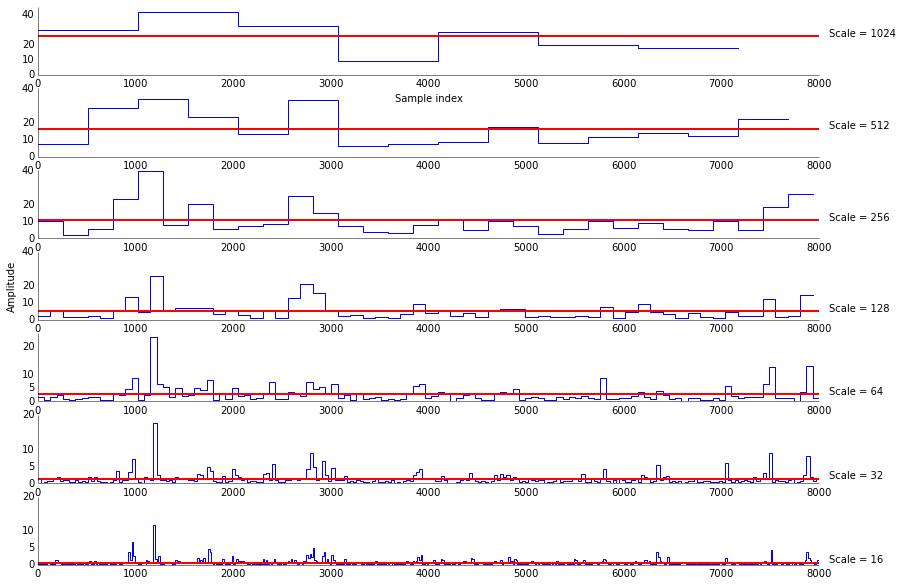

In [5]:
def trends(X,scale,m=1):
    t = arange(X.shape[0])
    segments = arange(0,X.shape[0]-scale+1,scale)
    RMS = []
    for i0 in segments:
        i1 = i0+scale
        t0 = t[i0:i1]
        C = polyfit(t0,X[i0:i1],m)
        fit = polyval(C,t0)
        RMS.append( sqrt(((X[i0:i1]-fit)**2).mean()) )
    return array(RMS)

RW = cumsum(multifractal-multifractal.mean())
scales = 2**arange(4,11)
#[16,32,64,128,256,512,1024];
m = 1

figure(figsize=(14,10))
RMS = {}
for si, scale in enumerate(scales):
    subplot(len(scales),1,len(scales)-si)
    t = arange(0,RW.shape[0]+1,scale)
    RMS[scale] = trends(RW,scale,m)
    step(t,r_[RMS[scale],RMS[scale][-1]],where='post')
    plot(xlim(),r_[1,1]*RMS[scale].mean(),'r',lw=2.0)
    text(8100,RMS[scale].mean(),'Scale = %d'%scale)
    if scale < 128:
        yticks([0,5,10,20])
    else:
        yticks([0,10,20,40])

xlabel('Sample index')
subplot(len(scales),1,len(scales)//2+1)
ylabel('Amplitude')

if SAVE: savefig('figure4.png')

In [6]:
def trends(X,scale,m=1):
    X = X[:X.shape[0]-X.shape[0]%scale].reshape(-1,scale)
    i = arange(scale,dtype='f8')
    RMS = zeros(X.shape[0],'f8')
    for j in xrange(X.shape[0]):
        C = polyfit(i,X[j],m)
        fit = polyval(C,i)
        RMS[j] = sqrt(((X[j]-fit)**2).mean())
    return RMS

def comp_Fs(X,scales,m=1):
    RW = cumsum(X-X.mean())
    return array([ sqrt((trends(RW,scale,m)**2).mean()) for scale in scales ])
    
scales = floor(2.0**arange(4,11,0.25)).astype('i4')
F_mf = comp_Fs(multifractal,scales,1)
F_1f = comp_Fs(monofractal,scales,1)
F_wn = comp_Fs(whitenoise,scales,1)

Figure 5
--------

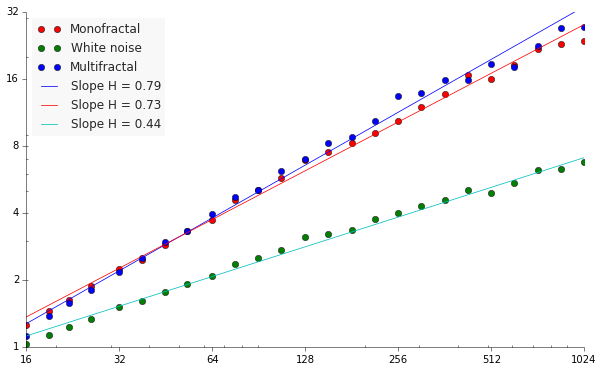

In [7]:
figure(figsize=(10,6))
loglog(scales,F_1f,'ro',label='Monofractal')
loglog(scales,F_wn,'go',label='White noise')
loglog(scales,F_mf,'bo',label='Multifractal')
axis([16,1024,1,32])
xticks(2**arange(4,11),2**arange(4,11))
yticks(2**arange(0,6),2**arange(0,6))

def plot_logfit(x,y,lc):
    C = polyfit(log2(x),log2(y),m)
    plot(x,2**polyval(C,log2(x)),lc,label='Slope H = %0.2f'%C[0])

plot_logfit(scales,F_mf,'b')
plot_logfit(scales,F_1f,'r')
plot_logfit(scales,F_wn,'c')
legend(loc='upper left')

if SAVE: savefig('figure5.png')

Figure 7
--------

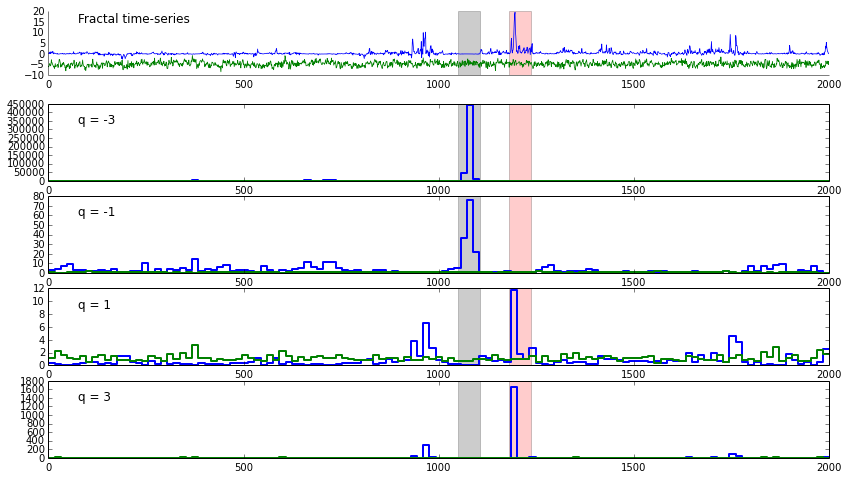

In [8]:
from matplotlib import patches

subplot(611)
i1 = 2000
plot(multifractal[:i1])
plot(monofractal[:i1]-5)
yl = ylim()
gca().add_patch( patches.Rectangle((1050,yl[0]),55,yl[1]-yl[0],alpha=0.2,fc='k') )
gca().add_patch( patches.Rectangle((1180,yl[0]),55,yl[1]-yl[0],alpha=0.2,fc='r') )
text(75,0.75*yl[1],'Fractal time-series',fontsize=12)
    
RWm = cumsum(multifractal-multifractal.mean())[:i1]
RW1 = cumsum(monofractal-monofractal.mean())[:i1]

j = 2
for q in [-3,-1,1,3]:
    subplot(5,1,j); j += 1
    rms = trends(RWm,16,1)
    step(arange(rms.shape[0]+1)*16,r_[rms,rms[-1]]**q,where='post',lw=2.0)
    rms = trends(RW1,16,1)
    step(arange(rms.shape[0]+1)*16,r_[rms,rms[-1]]**q,where='post',lw=2.0)
    yl = ylim()
    gca().add_patch( patches.Rectangle((1050,yl[0]),55,yl[1]-yl[0],alpha=0.2,fc='k') )
    gca().add_patch( patches.Rectangle((1180,yl[0]),55,yl[1]-yl[0],alpha=0.2,fc='r') )
    text(75,0.75*yl[1],'q = %d'%q,fontsize=12)

if SAVE: savefig('figure7.png')

Figure 8
--------

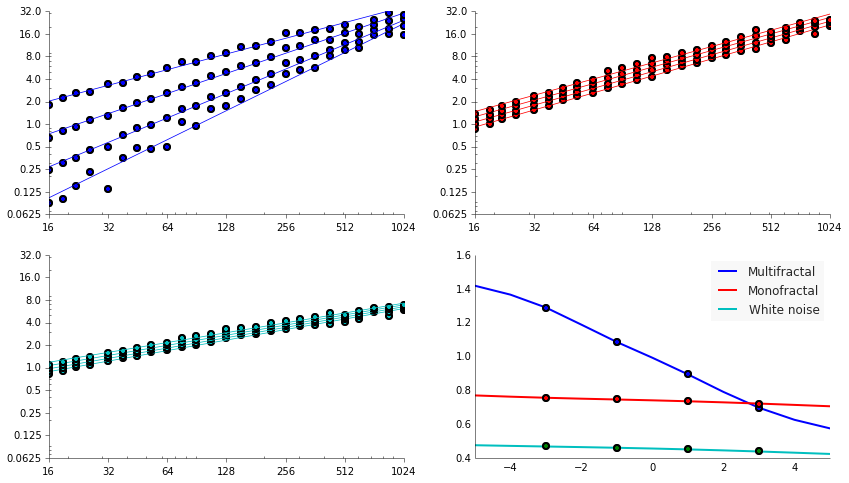

In [9]:

def comp_Fqs(X,scales,q,m=1):
    RW = cumsum(X-X.mean())
    if q == 0:
        return array([ exp(0.5*mean(log(trends(RW,scale,m)**2))) for scale in scales ])
    return array([ pow((trends(RW,scale,m)**q).mean(),1.0/q) for scale in scales ])

def plot_Fqs(X,scales,qs,plotq,c):
    Hs = []
    for q in qs:
        Fq = comp_Fqs(X,scales,q,1)
        Hs.append(polyfit(log2(scales),log2(Fq),1)[0])
        if q in plotq:
            loglog(scales,Fq,c+'o',markeredgewidth=2.0)
            axis([16,1024,2**-4,32])
            xticks(2**arange(4,11),2**arange(4,11))
            yticks(2.0**arange(-4,6),2.0**arange(-4,6))
            plot_logfit(scales,Fq,c)
    return array(Hs)

scales = floor(2.0**arange(4,11,0.25)).astype('i4')
qs = arange(-5,6)
plotqs = [-3,-1,1,3]
subplot(221)
Hmf = plot_Fqs(multifractal,scales,qs,plotqs,'b')
subplot(222)
H1f = plot_Fqs(monofractal,scales,qs,plotqs,'r')
subplot(223)
Hwn = plot_Fqs(whitenoise,scales,qs,plotqs,'c')

subplot(224)
plot(qs,Hmf,'b',lw=2.0,label='Multifractal')
plot(qs,H1f,'r',lw=2.0,label='Monofractal')
plot(qs,Hwn,'c',lw=2.0,label='White noise')
plot(plotqs,Hmf[[2,4,6,8]],'bo',lw=2.0,mew=2.0)
plot(plotqs,H1f[[2,4,6,8]],'ro',lw=2.0,mew=2.0)
plot(plotqs,Hwn[[2,4,6,8]],'go',lw=2.0,mew=2.0)
xlim(qs[0],qs[-1])
legend()

if SAVE: savefig('figure8.png')

Figure 9
--------

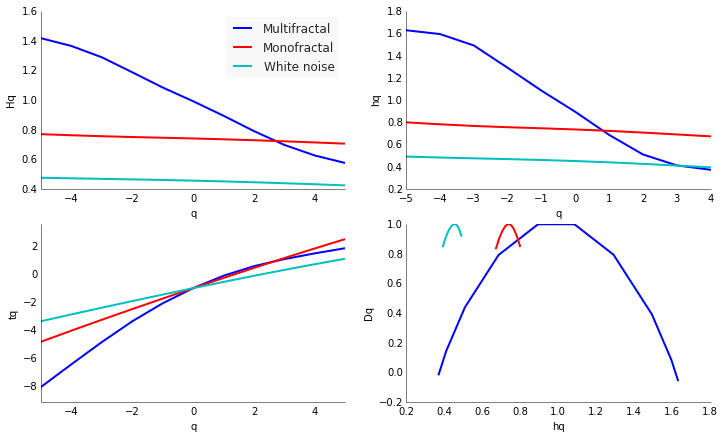

In [10]:
figure(figsize=(12,7))

subplot(221)
plot(qs,Hmf,'b',lw=2.0,label='Multifractal')
plot(qs,H1f,'r',lw=2.0,label='Monofractal')
plot(qs,Hwn,'c',lw=2.0,label='White noise')
xlim(qs[0],qs[-1])
xlabel('q'); ylabel('Hq')
legend()

subplot(223)
tqmf = Hmf*qs - 1
plot(qs,tqmf,'b',lw=2.0,label='Multifractal')
tq1f = H1f*qs - 1
plot(qs,tq1f,'r',lw=2.0,label='Monofractal')
tqwn = Hwn*qs - 1
plot(qs,tqwn,'c',lw=2.0,label='White noise')
xlabel('q'); ylabel('tq')
margins(0,0.1)

hqmf = diff(tqmf)/(qs[1]-qs[0])
hq1f = diff(tq1f)/(qs[1]-qs[0])
hqwn = diff(tqwn)/(qs[1]-qs[0])
Dqmf = (qs[:-1]*hqmf) - tqmf[:-1]
Dq1f = (qs[:-1]*hq1f) - tq1f[:-1]
Dqwn = (qs[:-1]*hqwn) - tqwn[:-1]

subplot(222)
plot(qs[:-1],hqmf,'b',lw=2.0,label='Multifractal')
plot(qs[:-1],hq1f,'r',lw=2.0,label='Monofractal')
plot(qs[:-1],hqwn,'c',lw=2.0,label='White noise')
xlabel('q'); ylabel('hq')

subplot(224)
plot(hqmf,Dqmf,'b',lw=2.0,label='Multifractal')
plot(hq1f,Dq1f,'r',lw=2.0,label='Monofractal')
plot(hqwn,Dqwn,'c',lw=2.0,label='White noise')
xlabel('hq'); ylabel('Dq');

if SAVE: savefig('figure9.png')

The concepts behind MFDFA should be clear now. Parts of this code are slow due to repeated execution of the polyval function. Application of the methods to large datasets can be made possible through Numpy module's vectorized polyfit and polyval (hidden in numpy.polynomials.polynomials). Head over to another notebook [Introduction to (faster) MDFA in Python](mdfafast.html) to see how to use the vectorized functions to get more results and faster.